In [1]:
%matplotlib inline

from functions import *
import statsmodels.api as sm

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn'])

# Chapter 7: Ulysses' Compass

This chapter is about over/under-fitting and regularization.


#### Dealing with Underfitting:

1. Add more parameters.


#### Dealing with Overfitting:

1. Use a *regularizing prior* (this is equivalent to a *penalized likelihood* for non-Bayesian methods)

2. Use a scoring device to model the prediction accuracy, such as *cross-validation* or an *information criterion*


#### How not to select a model:

The most common form of model selection is *stargazing*--that is, looking for parameters that are significant. p-values are not designed to help navigate between overfitting and underfitting--they are a device for null hypothesis testing. Predictors that improve prediction are not always statistically significant, and statistically significant predictors do not always improve prediction. Also, the 5% threshold is arbitrary and does not optimize anything to do with model performance.

## 7.1 The problem with parameters

In the previous chapter we looked at examples where adding parameters to models could mess up causal inference. However, in all those models, the "confounded" models with more parameters still produced a better "fit".

There is danger to adding more parameters, even if we only care about prediction and not inference.

### 7.1.1 More parameters always improve fit

Overfitting occurs when a model learns too much from the sample--both *regular* and *irregular* features of the sample. The regular features are the targets of our learning because they generalize well or answer a question of interest. Irregular features are aspects of the data that do not generalize well, and so may mislead us.

Overfitting happens automatically, as statistical methods minimize *in-sample* loss.

You can think of a model as a method of data *compression*. The model compresses all of the information about the data (with some loss of information), but then can be used to reproduce the data (e.g., by generating a bunch of predictions). When the number of parameters is equal to the number of data points, the model simply becomes a re-expression of the data rather than a compression.

***

Here is a simple example of overfitting. In this example we try to determine the relationship between a species average body size and average brain size.

In [4]:
data = {'species' : ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens'],
'brain' : [438, 452, 612, 521, 752, 871, 1350],
'mass' : [37., 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]}
d = pd.DataFrame(data)
d

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


In [5]:
# Fit a simple linear regression
m_6_1 = smf.ols('brain ~ mass', data=d).fit()

# Fit increasingly large polynomial regressions up to order 6
m_6_2 = smf.ols('brain ~ mass + I(mass**2)', data=d).fit()
m_6_3 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3)', data=d).fit()
m_6_4 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4)', data=d).fit()
m_6_5 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d).fit()
m_6_6 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5) + I(mass**6)', data=d).fit()

C:\Users\alexa\Miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


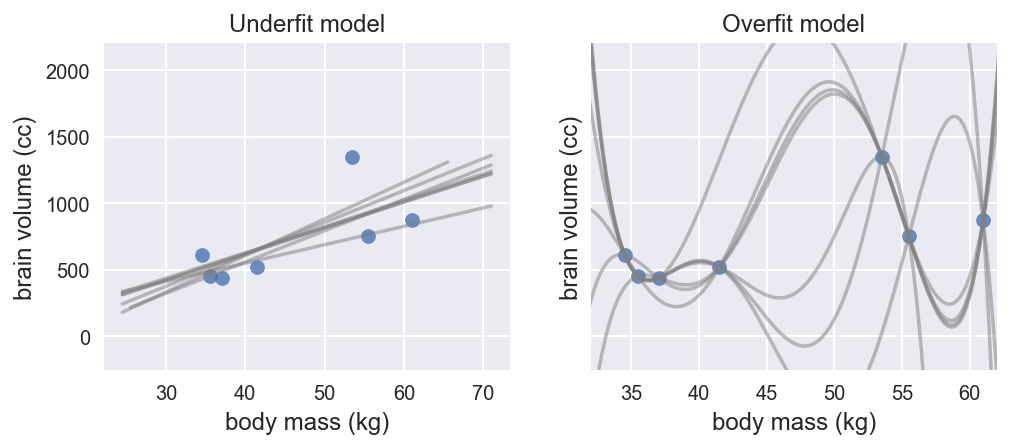

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.scatter(d.mass, d.brain, alpha=0.8)
ax2.scatter(d.mass, d.brain, alpha=0.8)
for i in range(len(d)):
    d_new = d.drop(d.index[-i])
    m0 = smf.ols('brain ~ mass', d_new).fit()
    # need to calculate regression line
    # need to add intercept term explicitly
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min() - 10, x.mass.max() + 10, 50)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m0.predict(x_pred2)  # calculate predicted values
    ax1.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax1.set_xlabel('body mass (kg)', fontsize=12);
    ax1.set_ylabel('brain volume (cc)', fontsize=12)
    ax1.set_title('Underfit model')
    
    # fifth order model
    m1 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d_new).fit()
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min()-10, x.mass.max()+10, 200)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m1.predict(x_pred2)  # calculate predicted values from fitted model
    ax2.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax2.set_xlim(32,62)
    ax2.set_ylim(-250, 2200)
    ax2.set_xlabel('body mass (kg)', fontsize=12);
    ax2.set_ylabel('brain volume (cc)', fontsize=12)
    ax2.set_title('Overfit model')
plt.show()

In [7]:
m_6_7 = smf.ols('brain ~ 1', data=d).fit()

### 7.2.2. Information and uncertainty

We need to find a good way to measure a model's distance from the target. In this book, the approach that we use is spawned from Information Theory.

The basic insight is to ask: *How much is our uncertainty reduced by learning an outcome?*

There is a bunch of other text in the book that I don't follow, but ultimately the conclusion is that the **Information Entropy** function is the gold standard way to score uncertainty:

$$ H(p) = -E \log(p_i) = - \sum^n_{i=1} p_i \log(p_i)$$

Which translates to: "*The uncertainty contained in a probability distribution, H(p), is the average log-probability of the event*."

Where an "event" might refer to anything from a type of weather to a particular species of bird or a particular nucleotide in a DNA sequence.

To help demystify this function, we will write a short example. Suppose the true probability of rain is 0.3 and the true probability of shine is 0.7. Then:

$p_1 = 0.3$ ; $p_2 = 0.7$

$H(p) = - (p_1 \log(p_1) + p_2 \log(p_2))$

Suppose instead we live in a dessert where it rarely rains: $p_1 = 0.01$ and $p_2 = 0.99$. Now the entropy is:

In [8]:
# in Python
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

0.6108643020548935

The entropy has decreased as our uncertainty has decreased.

In contrast, adding additional possible outcomes will increase entropy. Consider the case where there is a chance or sun, rain, or snow:

In [9]:
# in Python
p = np.array([0.3, 0.7])
-np.sum(p * np.log(p))

0.6108643020548935

### 7.2.3 From entropy to accuracy

Entropy has given us a way to quantify uncertainty, which gives us a way to say precisely *how hard it is to hit the target*. What we need to compute the Entropy is a vector of probabilities for each sample (e.g., the probability of each observation occuring in the real world).

When we build models, we don't have access to the true probabilities, *p*. Instead, we have the probability of each observation *given the model parameters*.

This leads our model to have additional uncertainty on top of the real-world uncertainty. The distance between the entropy of our model and the entropy of the real-world is **divergence**: *The additional uncertainty induced by using probabilities from one distribution to describe another distribution*. This is often known as the *Kullback-Leibler divergence* or *K-L divergence*.

Suppose the tue chance of rain/shine is $p_1 = 0.3$ ; $p_2 = 0.7$, and our model guesses $p_1 = 0.25$ ; $p_2 = 0.75$. How much additional uncertainty have we introduced as a consequence of using q to approximate p? The formal answer has the formula:

$$D_{KL}(p, q) = \sum_i p_i (\log(p_i) - \log(q_i))$$

In [10]:
p = np.array([0.3, 0.7])
q = np.array([0.25, 0.75])

np.sum(p * (np.log(p) + np.log(q)))

-1.2281300611071073

In plainer language: *divergence is the average difference in log probabilities between the target(p) and model (q)*.

If q = p, then divergence is zero.

Importantly, divergence is asymmetric. If two models are the same distance from the target, the one with greater uncertainty will have lower divergence than the one with less uncertainty. This is because models with more uncertainty are "less surprised" by results that disagree with the model.

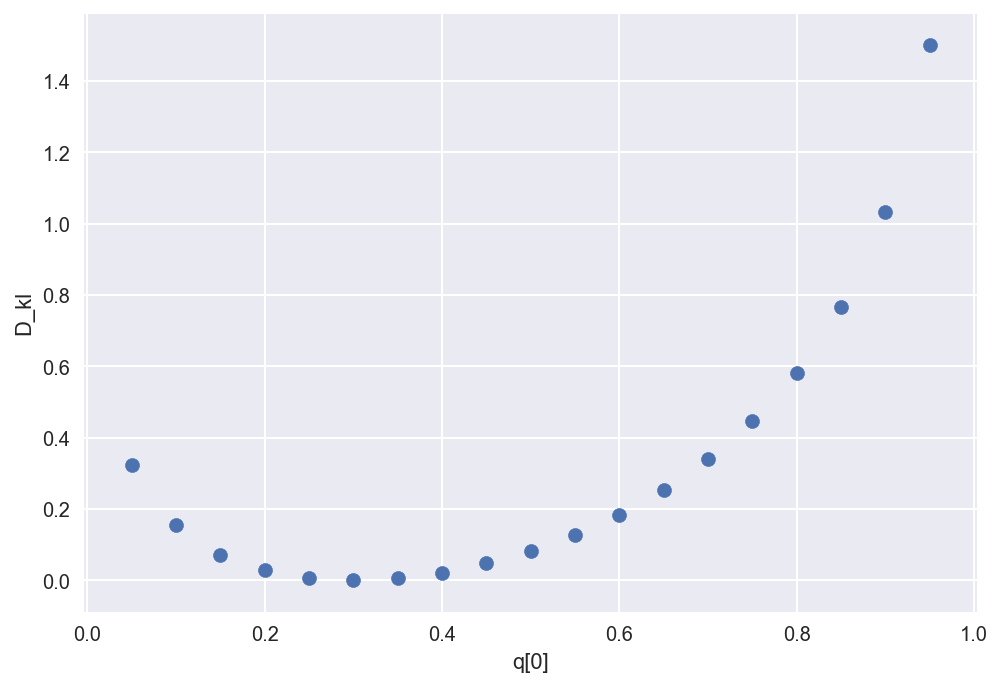

In [11]:
p = np.array([0.3, 0.7])
df = pd.DataFrame()

for i in np.linspace(0.05, 0.95, 19):
    q = np.array([i, 1 - i])
    d_kl = np.sum(p * (np.log(p) - np.log(q)))
    row = {'q': q[0], 'd_kl': d_kl}
    df = df.append(row, ignore_index=True)

plt.scatter(df['q'], df['d_kl']);
plt.xlabel('q[0]');
plt.ylabel('D_kl');

***

### 7.2.4 Estimating divergence

To use $D_{KL}$ to compare model accuracy, it seems like we would need to know p. In the examples above we have assumed that p was known, but in the real-world we do not.

However, if our goal is just to compare the divergence of two models (q and r), the $E\log(p_i)$ terms from each of the models cancels out. This means that we can estimate how far q and r are from eachother, as well as which is closer to the target (p), without knowing the target.

We only need $E\log(q_i)$ and $E\log(p_i)$ in order to compare the divergence of two models.

In practice, the **log-score** is used:

$$S(q) = \sum_i \log(q_i)$$

It is an estimate of $E\log(q_i)$, just without the final step of dividing by the number of observations. Here, larger values indicate a higher probability (i.e., the data are more congruent with the model).

***

#### LPPD

For a Bayesian model, instead of having a single log-score for each model, we have a distribution of log-scores based on the posterior distribution. This is the **log-pointwise-predictive-density** (lppd).

$$lppd(y, \theta) = \sum_i \log(\frac{1}{S}) \sum_s p(y_i | \theta_s)$$

Where $S$ is the number of samples and $\theta_s$ is the s-th set of sampled parametere values in the posterior distribution.

In English: 

- $p(y_i | \theta_s)$ -- For each parameter value ($\theta_s$), compute the conditional probability of observing the observation $y_i$.


- $\log(\frac{1}{S}) \sum_s p(y_i | \theta_s)$ -- Sum over each parameter value and divide by S to get the average probability of observing $y_i$ given the set of parameter values. Take the log to get the average log-probability.

- $\sum_i \log(\frac{1}{S}) \sum_s p(y_i | \theta_s)$ -- Repeat the above for each observation $i = 1, ... , S$ take the sum to get the lppd. 


**Note**: If we multiply the lppd by `-2`, we get a term called **deviance**. The `-2` is just historical, but means that smaller values are better.

### 7.2.5 Scoring the right data

Log-scores and lppd are only useful when used out-of-sample. If used in-sample, they always improve as the model gets more complex.

We should compare the training deviance to the test deviance.

***

## 7.2 Regularization

Models tend to get overexcited by the training sample. When priors are very flat, the machine interprets this to mean that every parameter is equally plausible; as a result, the machine returns a posterior that encodes as much of the training sample (by way of the likelihood function) as possible.

One way to minimize overfitting is by using a "skeptical" prior. Most commonly, this is applied to a $\beta$ coefficient (i.e., slope) in a linear model. When properly turned, the model can reduce overfitting while still learning the regular features of a sample. If the prior is too skeptical, the model may underfit.

Consider a prior for $\beta$:

$$\beta \sim Normal(0, 1)$$

Assuming the data are standardized to a mean=0 and sd=1, this prior tells the machine that it should be skeptical of values on the tails. For example, we only assign a 5% probability to values above 2 / below -2. Since this is a standardized variable, we can interpret this to mean: A change in 1 standard deviation in $x$ is unlikely to produce 2 units of change in the outcome.

Some other notes on regularizing priors:

- A skeptical prior will always fit worse in-sample. However, they may perform better out of sample.

- Skeptical priors have a larger impact when the sample is small. When there are lots of data the effect of the prior is diminished.




***

## 7.4 Predicting predictive accuracy



### 7.4.1 Cross-validation

Cross-validation can be very computationally expensive for Bayesian models, especially Leave-one-out cross validation (LOOCV), which is commonly used.

One approach is to approximate the LOOCV score using *Pareto-smoothed importance sampling leave-one-out cross-validation* (LOOIS). Roughly speaking, this method puts more emphasis on samples that have a larger "informational impact" on the posterior predictions.

LOOIS also has the benefit of warning us when it is inaccurate.

### 7.4.2 Information Criteria

Information criteria construct a theoretical estimate of the relative out-of-sample KL Divergence. It so happens that the difference between in-sample and out-of-sample deviance increases by almost exactly 2 points for each additional parameter (in an ordinary linear regression with flat priors). This is not a coincidence, although I don't understand why this happens to be true.

This phenomenon motivates information criteria. The best known is AIC:

$$AIC = D_{train} + 2p = -2lppd + 2p$$

Where $p$ is the number of free parameters in the posterior distribution. What AIC tells us is that the demensionality of the posterior distribution is a natural measure of the model's tendency to overfit. I.e., more complex models tend to overfit more, with deviance increasing directly in proportion to the number of parameters.

AIC is mostly obsolete now, as it is limited by assumptions:

1. The priors are flat (or nearly flat)

2. The posterior is approximately multivariate Normal

3. Sample size *N* is much larger than the number of parameters *k*

#### WAIC

The *Widely Applicable Information Criterion* (WAIC) makes no assumptions about the shape of the posterior. It provides an approximation of the out-of-sample deviance that converges to the LOOCV in a large sample. However, in a finite sample it can disagree (because its target is the OOS KL-Divergence rather than CV score). Unfortunately, generality comes at the expense of an elegant formula:

$$WAIC(y, \theta) = -2(lppd - \sum_i var_{\theta} \log p(y_i | \theta))$$

Where $y$ are the observations and $\theta$ is the posterior distribution. $\sum_i var_{\theta} \log p(y_i | \theta$ is the penalty term.

This formula can be thought of as: "Compute the log-probabilities for each observation. Take the variance of the log-probabilities (for each sample) and sum these variances to get the total penalty." I.e., each observation has its own personal penalty, which allows us to assess overfitting risk at the level of each individual observation.

The penalty term is some times called the *effective number of parameters*, labeled $p_{WAIC}$. This is a historical term, but does not make much mathematical sense (overfitting risk has more to do with how the parameters are related than the number of parameters). However, this is language that is used. In the book, it is referred to as the *Akaike penalty*.

The box below has an example of how WAIC is calculated manually.

***

#### Computing WAIC Manually

In [121]:
# Code 7.20
cars = pd.read_csv('Data/cars.csv')

with pm.Model() as m_742:
    a = pm.Normal('a', 0, 100)
    b = pm.Normal('b', 0, 5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + b * cars['speed'])
    dist = pm.Normal('dist', mu, sigma, observed=cars['dist'])
    
    tm_742 = pm.sample(1000, tune=200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains: 100%|█████████████| 4800/4800 [00:04<00:00, 1059.05draws/s]
The acceptance probability does not match the target. It is 0.9045341000277982, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9257282003539526, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9003290363173975, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8945294469437723, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [122]:
pm.summary(tm_742)[0:3]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,-16.745663,6.055911,0.214487,-28.813570,-5.357615,658.656191,1.000566
b,3.880895,0.369844,0.012584,3.160828,4.597307,716.282714,1.000520
sigma,13.817781,1.188081,0.018367,11.747452,16.260739,3963.343679,0.999717


In [103]:
# Code 6.21
# Compute the log probability of each observation
n_cases = len(cars)
n_samples = len(tm_742['mu'][:,0])

def logprob(trace, s):
    mu_of_sample = trace['mu'][:,s]
    sigma_of_sample = trace['sigma']
    return stats.norm.logpdf(cars['dist'][s], mu_of_sample, sigma_of_sample)

# Produces a 50 x 2000 matrix (50 obs * 2000 samples)
log_probs = np.array([logprob(tm_742, s) for s in range(n_cases)])

In [147]:
np.log(np.sum(np.exp(log_probs[0]))) - np.log(n_samples)

-3.628646736557919

In [158]:
# Code 6.22
# With the log probabilities, compute the Bayesian deviance, lppd.
# We average the samples in each row, take the log, and sum them.
# In order to calculate these with precision, we do this averaging on the log-scale.

# Convert log probabilities to exponents and then take the average
# (sum them, take the log, and subtract the log of the number of samples)
def log_sum_exp(log_probs, i):
    return np.log(np.sum(np.exp(log_probs[i]))) - np.log(n_samples)

lppd = np.array([log_sum_exp(log_probs, i) for i in range(n_cases)])

In [159]:
lppd[0:5]

array([-3.62864674, -3.92014794, -3.6726332 , -3.92965436, -3.58274377])

In [160]:
# Code 6.23

# Compute the variance of the log probabilities (these are the WAIC penalties before summation)
pWAIC = np.array([np.var(log_probs[i]) for i in range(n_cases)])

In [161]:
pWAIC[0:5]

array([0.02220862, 0.09283931, 0.02017705, 0.05876122, 0.01094816])

In [172]:
# Code 6.24
# Putting it together to compute WAIC

 # Compute this as a vector rather than summing it all up now
WAIC = -2 * (lppd - pWAIC)
print(np.sum(WAIC))

421.5989851558248


In [173]:
# Code 6.25
# Computing the SE
np.sqrt(n_cases * np.var(WAIC))

16.191422962727028

Compare this value to what is generated by the WAIC function in PyMC3 (there will be some simulation variance, but this will be much smaller than the SE)/:

In [164]:
pm.waic(tm_742, m_742)

C:\Users\alexa\Miniconda3\lib\site-packages\pymc3\stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=421.3350438993373, WAIC_se=16.277732500263145, p_WAIC=4.019272825417029, var_warn=1)

### Pointwise WAIC

With point-wise WAIC we can also see which points contribute most to overfitting (not sure if this is always the case [but it likely is], but the samples at extreme Y-values for their X-value contribute the most to overfitting:

C:\Users\alexa\Miniconda3\lib\site-packages\pymc3\stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


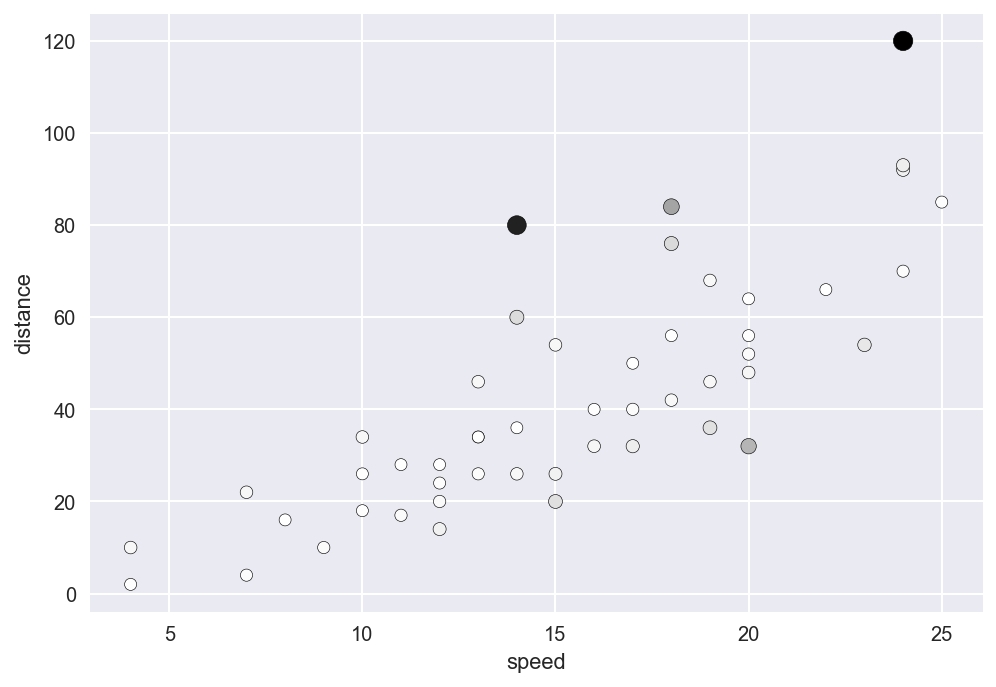

In [200]:
pw_waic = pm.waic(tm_742, m_742, pointwise=True)

plt.scatter(cars['speed'], cars['dist'], edgecolor='black',
            s=pw_waic[-1]*5,  c=pw_waic[-1])
plt.xlabel('speed')
plt.ylabel('distance');

### Comparing models with WAIC

In [201]:
# Create a second model for comparison: dist ~ 1 (inercept only)
with pm.Model() as m_742b:
    a = pm.Normal('a', 0, 100)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a)
    dist = pm.Normal('dist', mu, sigma, observed=cars['dist'])
    
    tm_742b = pm.sample(500, tune=200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a]
Sampling 4 chains: 100%|█████████████| 2800/2800 [00:02<00:00, 1099.65draws/s]
The acceptance probability does not match the target. It is 0.9247021852994162, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9151404666134031, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9082422685195137, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9123493043874351, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [202]:
pm.summary(tm_742b)[0:2]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,43.237012,3.315558,0.148358,37.211499,50.357517,479.335953,1.000204
sigma,21.807441,1.740283,0.040125,18.359273,25.223092,1987.410122,0.999068


In [208]:
waic_compare = pm.compare({m_742 : tm_742, 
                           m_742b: tm_742b})
print(waic_compare)

C:\Users\alexa\Miniconda3\lib\site-packages\pymc3\stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
C:\Users\alexa\Miniconda3\lib\site-packages\pymc3\stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


     WAIC pWAIC  dWAIC weight     SE    dSE var_warn
0  421.34  4.02      0   0.96  16.28      0        1
1  473.79  2.97  52.45   0.04  15.84  13.69        1


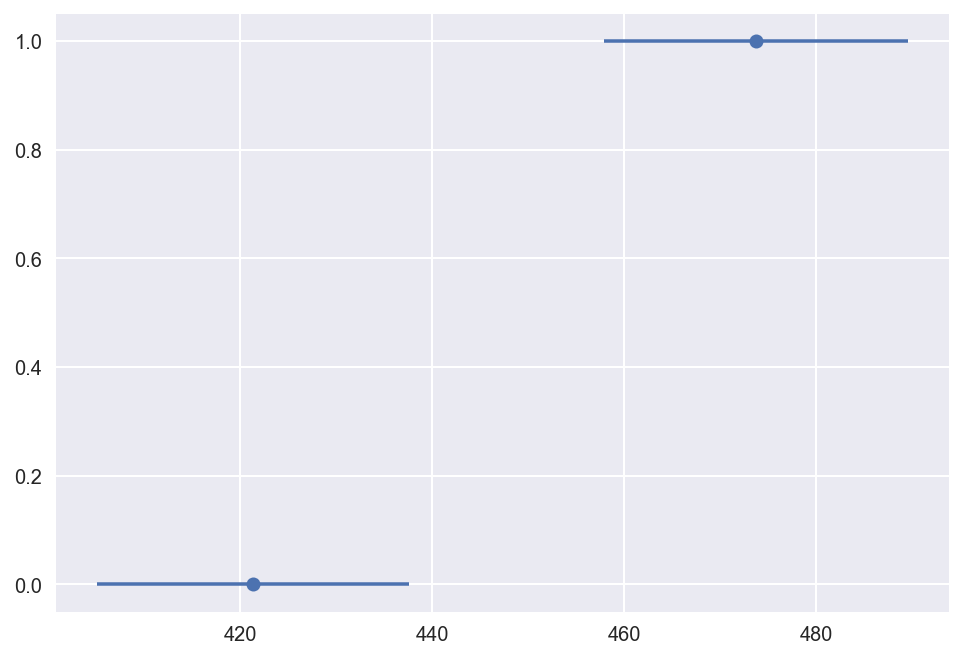

In [218]:
plt.errorbar(x=waic_compare['WAIC'], y=waic_compare.index, xerr=waic_compare['SE'], fmt = 'o',);

***

### 7.4.3 Comparing LOOCV, LOOIS, and WAIC

The book presents an example of a linear regression model fit with 1-5 parameters with N=20 or N=100 with different methods of estimating out-of-sample error (it's not exactly clear how this was done since CV and WAIC don't automatically perform model selection).

The conclusion is as follows, and was part of Watanabe's original conclusion: 
* LOOIS and WAIC are essentially the same in the context of linear models. 
* Differences may arise when the posterior distribution is not approximately Normal or if there are observations that stronly influence the posterior.
* LOOCV and LOOIS have higher variance as estimators of K-L Divergence, so we should expect WAIC to perform better in many cases. However, in practice the advantage is much smaller than the error.

## 7.5 Using cross-validatoin and information criteria

So far we have discussed two methods of improving out-of-sample predictions:
* Use regularizing prior
* Using cross-validation or information criteria to estimate the out-of-sample deviance.

These two methods can be combined.

So how do we use these methods to improve our models? One common way to use information criteria and cross-validation is to perform *model selection*. i.e., choosing the model that optimizes the criterion and discarding the others. However, the book warns against doing this because this procedudre discards information about the relative accuracy contained in the differences among the LOOCV/LOOIS/WAIC values. Just as the posterior gives us information on how certain we are about parameter estimates (conditional on the modeL), the relative model accuracy gives us information on how certain we are about the models (conditional on the set of models compared). [Not sure I fully understand that]

If we are interested in causal inference, maximizing predictive accuracy will not get us there. Highly confounded models can produce good predictions, but they may be poor models to use to design interventions.

Instead of model selection, the book focuses on *model comparison*. 

### 7.5.1 Model mis-selection

The book provides an example of how WAIC (and other criteria/cross-validation) are not useful for inferring causation or determining the effect of a variable. In the example of `plant_growth ~ fungicide`, including `fungus` as a variable improves WAIC, even though we know that `fungicide` is the cause of `fungus`. Additionally `plant_growth ~ fungicide` does not have s substantially better WAIC than a model with just the intercept. However, we know that `fungicide` has an impact on `plant_growth` from the posterior distribution (and also we invented the data); the effect is just small.

When we compute WAIC, we can a standard error for the WAIC also. When we compare the difference in WAIC between two models, there is a standard error for that difference as well. We can think of the out-of-sample accuracy as being Normally distributed with a mean equal to the QAIC and a standard deviation equal to its standard error. Thus , we can compute confidence intervals for WAICs and the difference between two WAICs.

In [ ]:
# Add code to compute / compare WAIC for different models